In [2]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from tifffile import imread, imsave
from csbdeep.utils import Path, normalize
from csbdeep.utils.tf import keras_import
keras = keras_import()


from zipfile import ZIP_DEFLATED

from glob import glob
from tqdm import tqdm

from csbdeep.io import save_tiff_imagej_compatible

from stardist import export_imagej_rois, random_label_cmap
from stardist.models import StarDist2D

from skimage import img_as_float32, img_as_ubyte, img_as_float

import cv2

## DATA

In [1]:
Data_folder  = "/media/alain/DataWS6/Artem/otx/test"
Results_folder = "/media/alain/DataWS6/Artem/otx/result"

In [3]:
Region_of_interests = False
Mask_images = True
Tracking_file = False

## PREDICTION

### Model

In [4]:
model = StarDist2D.from_pretrained('2D_versatile_fluo')

Found model '2D_versatile_fluo' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.


### Image Normalization

Stacks are now beeing predicted
Performing prediction on: want_test.aivia.tif


<ipython-input-5-6b0039440480> (59): <tifffile.imsave> is deprecated. Use tifffile.imwrite
<ipython-input-5-6b0039440480> (61): <tifffile.imsave> is deprecated. Use tifffile.imwrite


<Figure size 1440x360 with 0 Axes>

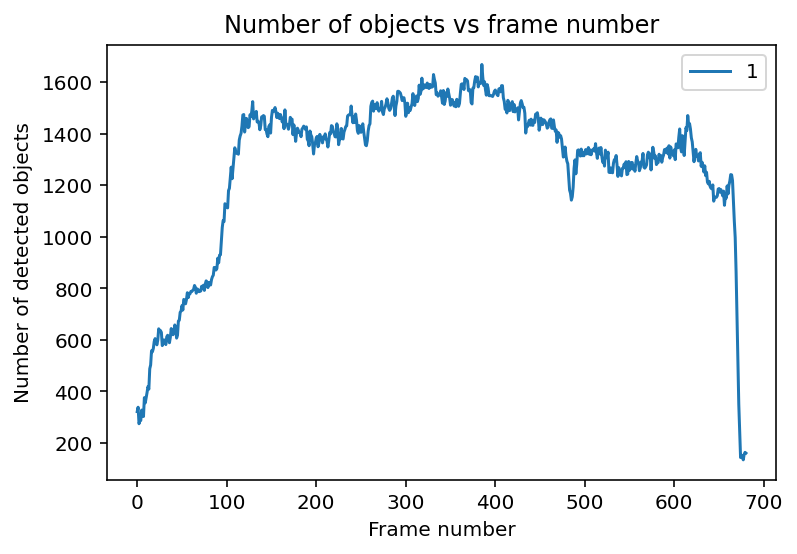

Predictions completed


In [5]:
print("Stacks are now beeing predicted")
np.random.seed(42)
lbl_cmap = random_label_cmap()


axis_norm = (0,1)

for image in os.listdir(Data_folder):
    print("Performing prediction on: "+image)

    Number_of_nuclei_list = []
    Number_of_frame_list = []

    timelapse = imread(Data_folder+"/"+image)

    short_name = os.path.splitext(image)     
    
    timelapse = normalize(timelapse, 1,99.8, axis=(0,)+tuple(1+np.array(axis_norm)))
    

    if Region_of_interests: 
        polygons = [model.predict_instances(frame)[1]['coord'] for frame in tqdm(timelapse)]    
        export_imagej_rois(Results_folder+"/"+str(short_name[0]), polygons, compression=ZIP_DEFLATED)  
    
    n_timepoint = timelapse.shape[0]
    prediction_stack = np.zeros((n_timepoint, timelapse.shape[1], timelapse.shape[2]))
    Tracking_stack = np.zeros((n_timepoint, timelapse.shape[2], timelapse.shape[1]))
    
# Analyse each time points one after the other
    
    if Mask_images or Tracking_file:
        for t in range(n_timepoint):
            img_t = timelapse[t]
            labels, polygons = model.predict_instances(img_t)      
            prediction_stack[t] = labels
            Nuclei_array = polygons['coord']
            Nuclei_array2 = [str(t), Nuclei_array.shape[0]]
            Number_of_nuclei_list.append(Nuclei_array2)
            Number_of_frame_list.append(t)
        
# Create a tracking file for trackmate

            for point in polygons['points']:
                cv2.circle(Tracking_stack[t],tuple(point),0,(1), -1)

        prediction_stack_32 = img_as_float32(prediction_stack, force_copy=False)
        Tracking_stack_32 = img_as_float32(Tracking_stack, force_copy=False)
        Tracking_stack_8 = img_as_ubyte(Tracking_stack_32, force_copy=True)
      
        Tracking_stack_8_rot = np.rot90(Tracking_stack_8, axes=(1,2))
        Tracking_stack_8_rot_flip = np.fliplr(Tracking_stack_8_rot)

# Export a csv file containing the number of nuclei detected at each frame
        my_df = pd.DataFrame(Number_of_nuclei_list)
        my_df.to_csv(Results_folder+'/'+str(short_name[0])+'_Nuclei_number.csv', index=False, header=False)

        os.chdir(Results_folder)
        if Mask_images:
            imsave(str(short_name[0])+".tif", prediction_stack_32, compress=ZIP_DEFLATED)
        if Tracking_file:
            imsave(str(short_name[0])+"_tracking_file.tif", Tracking_stack_8_rot_flip, compress=ZIP_DEFLATED)
        
# Object detected vs frame number
    plt.figure(figsize=(20,5))
    my_df.plot()
    plt.title('Number of objects vs frame number')
    plt.ylabel('Number of detected objects')
    plt.xlabel('Frame number')
    plt.legend()
    plt.savefig(Results_folder+'/'+str(short_name[0])+'_Object_detected_vs_frame_number.png',bbox_inches='tight',pad_inches=0)
    plt.show()         

print("Predictions completed")   